In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.models import resnet50

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_from_disk

/home/thesis/anaconda3/envs/sg-diff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load model

In [2]:
CNN = 'ResNet-50' # 'ResNet-50' or 'VGG-16'
#DATASET = 'CelebA_male_Smiling'
DATASET = 'CelebA_drift_simulated_with_Male_Wearing_Earrings'

NUM_CLASSES = 1      # Gender classification (1 for binary classification)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


net = resnet50() # Loading ResNet-50 model (pretrained on ImageNet)
net.fc = nn.Linear(2048, NUM_CLASSES) # Changed the last layer of ResNet-50

# Load pre-trained net
net.load_state_dict(torch.load(f'./weights/{CNN}-{DATASET}.pth', weights_only=True))

<All keys matched successfully>

### Dataset

In [3]:
dataset = load_from_disk(f"data/CelebA/{DATASET}")

num_train = dataset["historical_train"].num_rows
num_validation = dataset["historical_test"].num_rows
num_test = dataset["datastream_no_drift"].num_rows
num_test_drift = dataset["datastream_drift"].num_rows

In [4]:
print("Train split (historical_train):{}, \n"
      "Validation split (historical_test):{}, \n"
      "Test split (datastream_no_drift):{}, \n"
      "Test split (datastream_drift):{}".format(num_train, num_validation, num_test, num_test_drift))

Train split (historical_train):155951, 
Validation split (historical_test):19114, 
Test split (datastream_no_drift):19076, 
Test split (datastream_drift):1349


In [5]:
class HFDatasetWrapper(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        #image = Image.open(BytesIO(item['image']))
        #image = Image.open(item['image'])
        image = item['image']
        label = 1. if item['Male'] else 0.
        #print(type(image))

        if self.transform:
            image = self.transform(image)

        return image, label, idx

In [6]:
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Dataloaders

In [7]:
BATCH_SIZE = 64

# Datasets
train_dataset = HFDatasetWrapper(dataset['historical_train'], transform=eval_transform)
val_dataset = HFDatasetWrapper(dataset['historical_test'], transform=eval_transform)
test_dataset = HFDatasetWrapper(dataset['datastream_no_drift'], transform=eval_transform)
test_dataset_drift = HFDatasetWrapper(dataset['datastream_drift'], transform=eval_transform)

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader_drift = DataLoader(test_dataset_drift, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

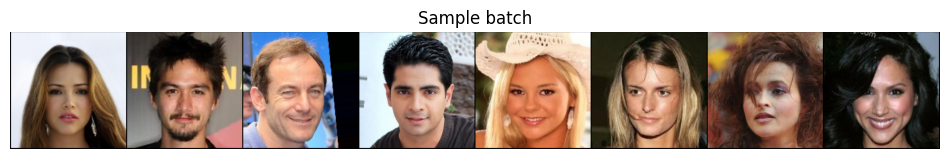

In [8]:
images, labels, _ = next(iter(train_dataloader))

imgs = images[:8] * torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)

# Show a grid of 8 images
grid = torchvision.utils.make_grid(imgs, nrow=8)#, normalize=True, value_range=(0, 1))

plt.figure(figsize=(12, 5))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')
plt.title("Sample batch")
plt.show()

### Test and find wrong predictions (drift = 100%)

In [9]:
net = net.to(DEVICE)
net.eval() # Set Network to evaluation mode

wrong_indices = []

with torch.no_grad():
    running_corrects = 0
    for images, labels, indices in tqdm(test_dataloader_drift):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        #_, preds = torch.max(outputs.data, 1) # multi-class classification
        preds = torch.sigmoid(outputs.squeeze(1)) >= 0.5 # binary classification

        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()

        # Get wrong preds
        wrong_mask = preds != labels.data
        batch_wrong_indices = indices[wrong_mask.cpu()]
        wrong_indices.extend(batch_wrong_indices.tolist())

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset_drift))

print('Test Accuracy: {}'.format(accuracy))
print('Num wrong preds: {}'.format(len(wrong_indices)))

100%|██████████| 22/22 [00:01<00:00, 13.85it/s]

Test Accuracy: 0.8917716827279466
Num wrong preds: 146


### Wrong predictions samples

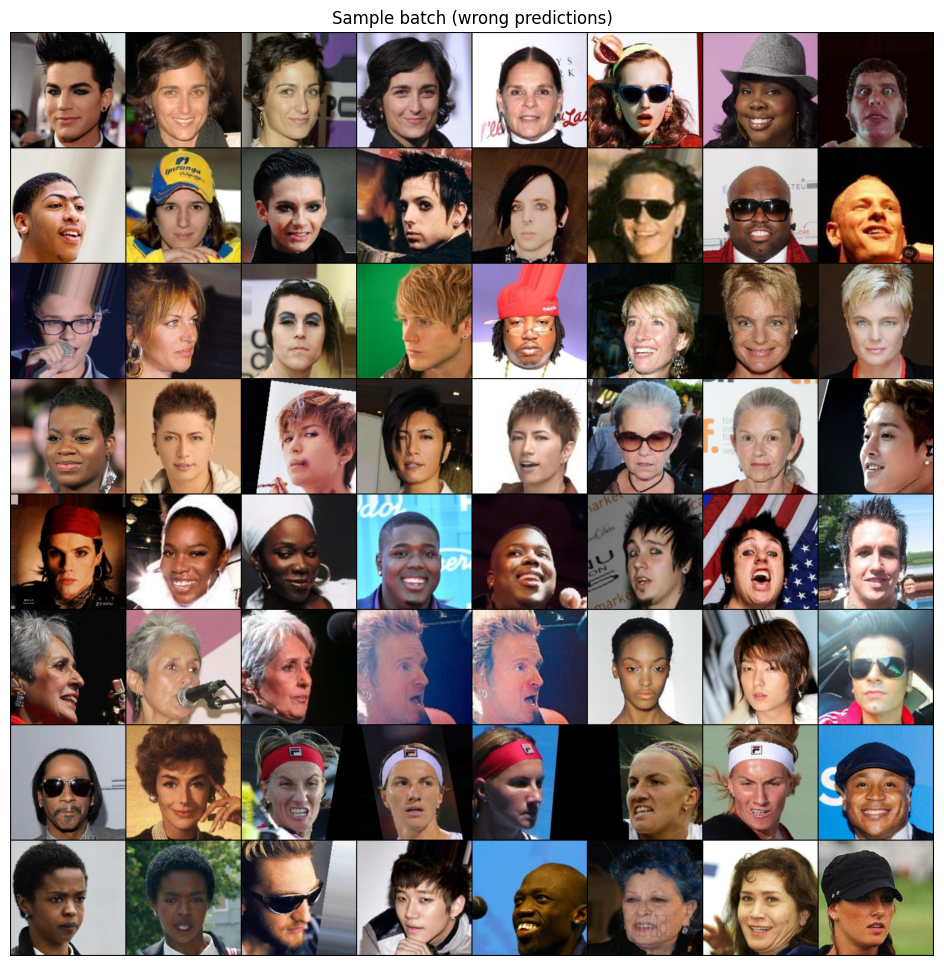

In [10]:
images = torch.stack([test_dataset_drift.__getitem__(idx)[0] for idx in wrong_indices])
#img, _, _ = test_dataset_drift.__getitem__(wrong_indices[0])

imgs = images[:64] * torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)

# Show a grid of 8 images
grid = torchvision.utils.make_grid(imgs, nrow=8)#, normalize=True, value_range=(0, 1))

plt.figure(figsize=(12, 12))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')
plt.title("Sample batch (wrong predictions)")
plt.show()

In [11]:
def tensor_to_rgb_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Convert a PyTorch tensor [C, H, W] to an RGB image in numpy [H, W, C]."""
    if isinstance(mean, list):
        mean = torch.tensor(mean).view(-1, 1, 1)
    if isinstance(std, list):
        std = torch.tensor(std).view(-1, 1, 1)
    img = tensor * std + mean
    #img = img.permute(1, 2, 0).numpy()
    img = np.transpose(img.numpy(), (1, 2, 0))
    img = np.clip(img, 0, 1)
    return img

In [12]:
def show_image_grid(images, rows=2, cols=5, figsize=(15, 6), filename='output.png'):
    """
    Visualize a list of images as a grid.

    Args:
        images (list of np.array): List of images in HWC format (Height, Width, Channels).
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
        figsize (tuple): Figure size for matplotlib.

    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i in range(rows * cols):
        if i < len(images):
            img = images[i]
            # If grayscale, remove channel dimension for display
            if img.ndim == 2:
                axes[i].imshow(img, cmap='gray')
            else:
                axes[i].imshow(img)
            axes[i].axis('off')
        else:
            axes[i].axis('off')  # Hide unused subplots

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

### Grad-CAM (Target: 'Male' = 0)

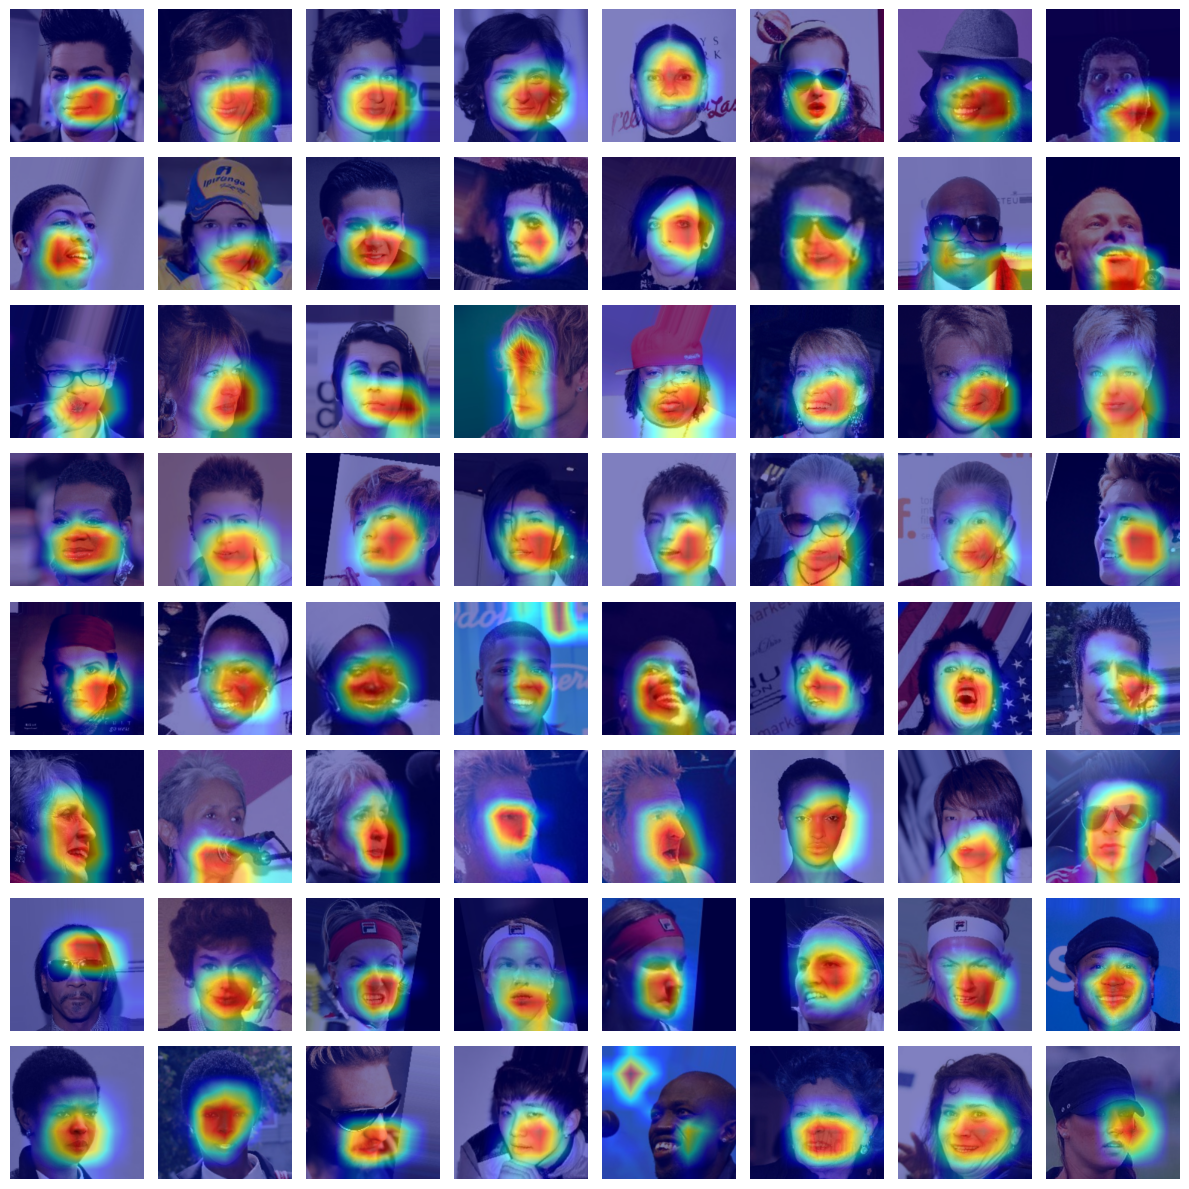

In [13]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


TARGET = -1  # Usually -1 = negative class, 1 = positive
# Target class: for binary (single output), 0 or 1
#targets = [ClassifierOutputTarget(0)]  # Usually 0 = negative class, 1 = positive
targets = [BinaryClassifierOutputTarget(TARGET)]  # Usually 0 = negative class, 1 = positive

target_layers = [net.layer4[-1]]

# Initialize GradCAM
cam = GradCAM(model=net, target_layers=target_layers)


img_cam_list = []

for img in images[:64]:
    tensor_img = img.unsqueeze(0)

    # Generate CAM
    grayscale_cam = cam(input_tensor=tensor_img, targets=targets)#, aug_smooth=True, eigen_smooth=True)

    # Since batch size = 1
    grayscale_cam = grayscale_cam[0, :]

    # Overlay the CAM on image
    visualization = show_cam_on_image(tensor_to_rgb_image(tensor_img[0]), grayscale_cam, use_rgb=True)
    img_cam_list.append(visualization)

show_image_grid(img_cam_list, rows=8, cols=8, figsize=(12, 12), filename='output-Not_Male.png')


### Grad-CAM (Target: 'Male' = 1)

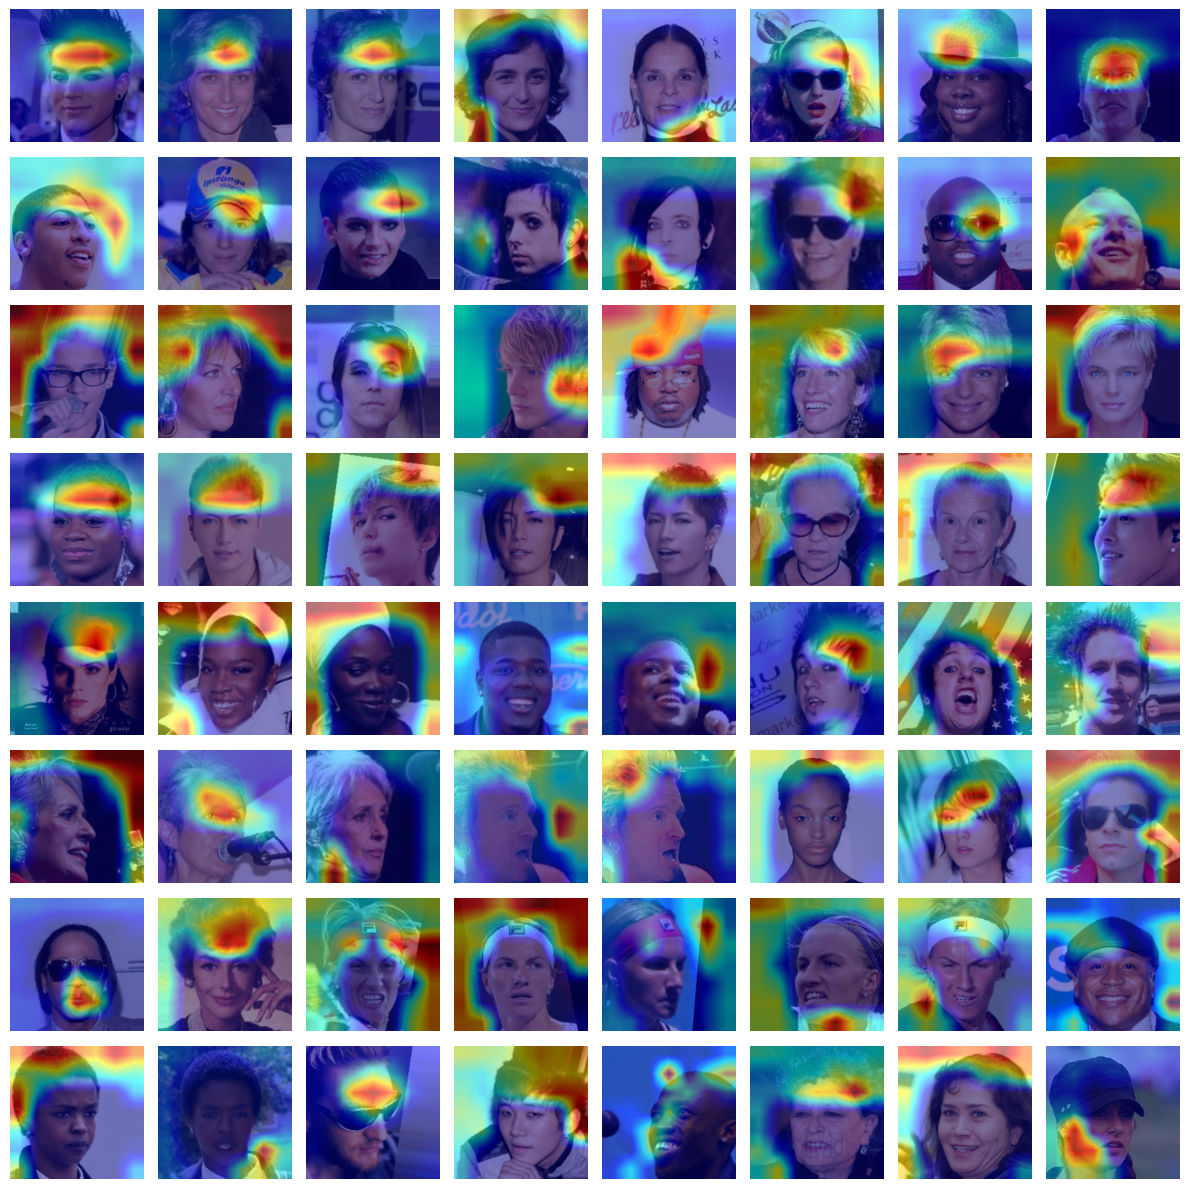

In [14]:
TARGET = 1 # Usually -1 = negative class, 1 = positive
# Target class: for binary (single output), 0 or 1
#targets = [ClassifierOutputTarget(0)]  # Usually 0 = negative class, 1 = positive
targets = [BinaryClassifierOutputTarget(TARGET)]  # Usually 0 = negative class, 1 = positive

target_layers = [net.layer4[-1]]

# Initialize GradCAM
cam = GradCAM(model=net, target_layers=target_layers)


img_cam_list = []

for img in images[:64]:
    tensor_img = img.unsqueeze(0)

    # Generate CAM
    grayscale_cam = cam(input_tensor=tensor_img, targets=targets)#, aug_smooth=True, eigen_smooth=True)

    # Since batch size = 1
    grayscale_cam = grayscale_cam[0, :]

    # Overlay the CAM on image
    visualization = show_cam_on_image(tensor_to_rgb_image(tensor_img[0]), grayscale_cam, use_rgb=True)
    img_cam_list.append(visualization)

show_image_grid(img_cam_list, rows=8, cols=8, figsize=(12,12), filename='output-Male.png')
